In [1]:
import os
import re
import keras
import urllib
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from collections import OrderedDict, Counter

from keras import metrics
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3

from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
sns.set_style('white')
plt.style.use('bmh')

Using TensorFlow backend.


In [2]:
train_X = np.load('./X_array.npy')
train_Y = np.load('./Y_array.npy')

In [3]:
test_X = np.load('./test_X_array.npy')
test_Y = np.load('./test_y_array.npy')

In [4]:
# Super simple CNN
model = Sequential()

# Input layer
model.add(Conv2D(80, activation='relu', 
                 kernel_size=(2, 2),
                 data_format = 'channels_last',
                 input_shape=(138,92,3)))

# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
# we could double the number of filters as max pool made the 
# feature maps much smaller 
# just not doing this to improve runtime
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- next layer ---
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))
# # --- regularize our model in order to prevent overfitting
model.add(Dropout(0.25))

# # --- next layer ---
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# # --- max pool ---
model.add(MaxPooling2D(pool_size=(2, 2)))
# # --- regularize our model in order to prevent overfitting
model.add(Dropout(0.25))

# flatten for fully connected classification layer
model.add(Flatten())
# --- fully connected layer ---
model.add(Dense(32, activation='relu'))
# # --- regularize our model in order to prevent overfitting
model.add(Dropout(0.5))
# --- Last layer: classification ---
model.add(Dense(20, activation='sigmoid'))

In [5]:
sgd = SGD(lr=0.01, momentum=0.9)

model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['mae', 'categorical_accuracy'])

batch_size = 12
early_stopping_monitor = EarlyStopping(patience = 3)

# Fit model on training data, validate on test
history = model.fit(train_X, train_Y,
                    validation_data=(test_X, test_Y),
                    batch_size=batch_size,
                    shuffle= True, 
                    epochs = 20,
                    callbacks = [early_stopping_monitor],
                    verbose=1)

Train on 4722 samples, validate on 1957 samples
Epoch 1/20
4722/4722 [==============================] - 14s - loss: 0.3797 - mean_absolute_error: 0.2376 - categorical_accuracy: 0.2338 - val_loss: 0.3489 - val_mean_absolute_error: 0.2169 - val_categorical_accuracy: 0.4415
Epoch 2/20
4722/4722 [==============================] - 11s - loss: 0.3090 - mean_absolute_error: 0.1813 - categorical_accuracy: 0.3257 - val_loss: 0.3484 - val_mean_absolute_error: 0.2023 - val_categorical_accuracy: 0.4415
Epoch 3/20
4722/4722 [==============================] - 11s - loss: 0.3019 - mean_absolute_error: 0.1761 - categorical_accuracy: 0.3520 - val_loss: 0.3471 - val_mean_absolute_error: 0.2035 - val_categorical_accuracy: 0.4415
Epoch 4/20
4722/4722 [==============================] - 11s - loss: 0.2998 - mean_absolute_error: 0.1748 - categorical_accuracy: 0.3554 - val_loss: 0.3471 - val_mean_absolute_error: 0.2107 - val_categorical_accuracy: 0.4415
Epoch 5/20
4722/4722 [==============================] - 

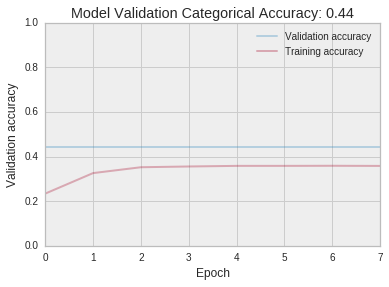

In [6]:
plt.plot(history.history['val_categorical_accuracy'], alpha = 0.3, label = 'Validation accuracy')
plt.plot(history.history['categorical_accuracy'], alpha =  0.3, label = 'Training accuracy')
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.ylim([0,1])
plt.legend(loc = 'best')
plt.title('Model Validation Categorical Accuracy: {0:.2f}'.format(history.history['val_categorical_accuracy'][-1]))
plt.show()

In [7]:
# Predicted lables per movie
preds = model.predict(test_X)
test_Y[0], preds[0]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 array([ 0.36822686,  0.25146699,  0.09352913,  0.17183883,  0.07516997,
         0.20130047,  0.08406134,  0.01381771,  0.14955924,  0.06351332,
         0.08859941,  0.20703191,  0.05276472,  0.08513974,  0.02519377,
         0.03820636,  0.12560099,  0.02480666,  0.01690729,  0.05039443], dtype=float32))

In [8]:
columns = ["Drama",
 "Horror",
 "Documentary",
 "Romance",
 "Adventure",
 "Comedy",
 "Family",
 "Fantasy",
 "Science Fiction",
 "Foreign",
 "Action",
 "Crime",
 "Music",
 "Thriller",
 "TV Movie",
 "History",
 "Mystery",
 "Animation",
 "War",
 "Western"
]

In [9]:
# Precision and Recall
# --Precision: number of true positives over the number of true positives plus the number of false positives
# --Recall: number of true positives over the number of true positives plus the number of false negatives
precision = dict()
average_precision = dict()
recall_score = dict()
recall = dict()
for i in range(20):
    precision[i], recall[i], _ = precision_recall_curve(test_Y[:, i],
                                                        preds[:, i])
    #average_precision[i] = average_precision_score(Y[:, i], preds[:, i])
    recall_score[i] = recall[i].mean()
    average_precision[i] = precision[i].mean()

names = ['id','data']
formats = ['f8','f8']
dtype = dict(names = names, formats=formats)
average_precision_np = pd.DataFrame(np.array(average_precision.items(), dtype=dtype))
average_precision_np['genre'] = list(columns)

recall_score_np = pd.DataFrame(np.array(recall_score.items(), dtype=dtype))
recall_score_np['genre'] = list(columns)

In [10]:
# Sort genres by precision and recall
average_precision_np = average_precision_np.sort_values(by = 'data', ascending=[0])
recall_score_np = recall_score_np.sort_values(by = 'data', ascending=[0])

# Average precision and recall across labels
mean_precision = average_precision_np.data.median()
mean_recall = recall_score_np.data.mean()

# F1 score
F1 = 2*(mean_precision*mean_recall)/(mean_precision+mean_recall)

# Print results
print ("# Overall precision and recall #")
print ('Mean Precision:'), round(mean_precision, 4)
print ('Mean Recall:'), round(mean_recall, 4)
print ('F1 Score:'), round(F1, 4)

# Overall precision and recall #
Mean Precision: 0.1014
Mean Recall: 0.4988
F1 Score: 0.1685


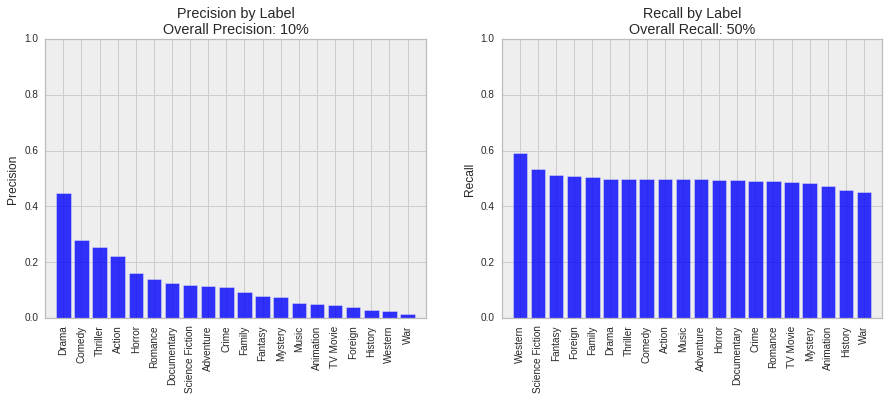

In [11]:
# Precision and recall by label
y_pos = np.arange(len(average_precision_np.genre)) + 1

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)

ax1 = plt.bar(y_pos, average_precision_np.data, align='center', alpha=0.8, color='b')
ax1 = plt.xticks(y_pos, average_precision_np.genre, rotation=90)
ax1 = plt.xlim([0,21])
ax1 = plt.ylim([0,1])
ax1 = plt.ylabel('Precision')
ax1 = plt.title('Precision by Label\nOverall Precision: {:.0f}%'.format(mean_precision*100))

ax2 = fig.add_subplot(1, 2, 2)

ax2 = plt.bar(y_pos, recall_score_np.data, align='center', alpha=0.8, color='b')
ax2 = plt.xticks(y_pos, recall_score_np.genre, rotation=90)
ax2 = plt.xlim([0,21])
ax2 = plt.ylim([0,1])
ax2 = plt.ylabel('Recall')
ax2 = plt.title('Recall by Label\nOverall Recall: {:.0f}%'.format(mean_recall*100))

plt.show()

In [12]:
# Look at the weights of the first layer
layer = model.layers[0]
# this actually returns a list 
# first element is W
# second element are all the biases b
weights = layer.get_weights()
# the weights are the number of pixels times the number of filters (hidden units)
print("Shape of W")
print(weights[0].shape)


Shape of W
(2, 2, 3, 80)


Shape of W
(2, 2, 3, 80)


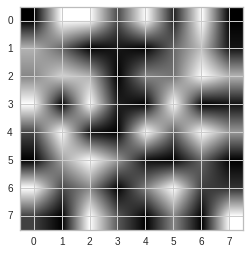

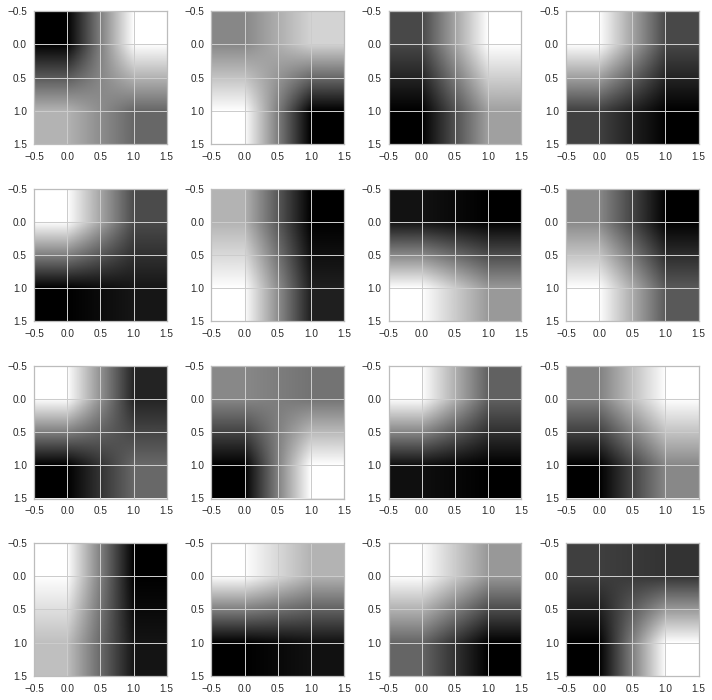

In [13]:
# Look at the weights of the first layer
layer = model.layers[0]
# this actually returns a list 
# first element is W
# second element are all the biases b
weights = layer.get_weights()
# the weights are the number of pixels times the number of filters (hidden units)
print("Shape of W")
print(weights[0].shape)
# look at just the first filter
w = weights[0][:,:,0,0]
w = w.reshape((2,2))
plt.imshow(w, cmap='gray')
# make a figure for the first 25 filters
filterTiles = np.array([])
index = 0
for i in range(4):
    filterRow = []
    for j in range(4):
        w = weights[0][:,:,0,index]
        w = w.reshape(2,2)
        w = w-np.min(w)
        w = w / np.max(w)
        filterRow.extend(w)
        index+=1
    filterRow = np.array(filterRow)
    if not filterTiles.shape[0] == 0:
        filterTiles = np.hstack([filterTiles, filterRow])
    else:
        filterTiles = filterRow

plt.imshow(filterTiles, cmap='gray')    
plt.show()

plt.figure(figsize=(10,10))
# make a figure for the first 25 filters
index = 0
for i in range(4):
    for j in range(4):
        w = weights[0][:,:,0,index]
        w = w.reshape(2,2)
        index+=1
        plt.subplot(4,4,index)
        plt.imshow(w, cmap='gray')
plt.tight_layout()
plt.show()

In [16]:
# Adapted from: https://github.com/fchollet/keras/issues/4465

# Get the convolutional part of a Xception network trained on ImageNet
model_xception_conv = Xception(weights='imagenet', include_top=False)
model_xception_conv.summary()

# Create input format (138,92,3)
input = Input(shape=(138,92,3), name = 'image_input')

# Use the generated model 
output_xception_conv = model_xception_conv(input)

# Add fully-connected layers 
layers = Flatten(name='flatten')(output_xception_conv)
layers = Dense(64, activation='relu', name='fc1')(layers)
layers = Dense(32, activation='relu', name='fc2')(layers)
layers = Dense(20, activation='sigmoid', name='predictions')(layers)

# Create the model for genre prediction 
pre_model = Model(input=input, output=layers)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, None, None, 32 864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, None, None, 32 128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, None, None, 32 0                                            
___________________________________________________________________________________________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("im...)`


In [17]:
# Compile the model
sgd = SGD(lr=0.01, momentum=0.9)
pre_model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['mae', 'categorical_accuracy'])

# fine-tune the model
batch_size = 12
history = pre_model.fit(train_X, train_Y,
                    validation_data=(test_X, test_Y),
                    batch_size=batch_size,
                    epochs = 10,
                    callbacks = [early_stopping_monitor],
                    verbose=1)

Train on 4722 samples, validate on 1957 samples
Epoch 1/10
4722/4722 [==============================] - 89s - loss: 0.2981 - mean_absolute_error: 0.1716 - categorical_accuracy: 0.3119 - val_loss: 0.3782 - val_mean_absolute_error: 0.1871 - val_categorical_accuracy: 0.3342
Epoch 2/10
4722/4722 [==============================] - 86s - loss: 0.2627 - mean_absolute_error: 0.1512 - categorical_accuracy: 0.3674 - val_loss: 0.3883 - val_mean_absolute_error: 0.1961 - val_categorical_accuracy: 0.3413
Epoch 3/10
4722/4722 [==============================] - 86s - loss: 0.2446 - mean_absolute_error: 0.1425 - categorical_accuracy: 0.3854 - val_loss: 0.3939 - val_mean_absolute_error: 0.1967 - val_categorical_accuracy: 0.2345
Epoch 4/10
4722/4722 [==============================] - 86s - loss: 0.2247 - mean_absolute_error: 0.1323 - categorical_accuracy: 0.4339 - val_loss: 0.4457 - val_mean_absolute_error: 0.1783 - val_categorical_accuracy: 0.2233
Epoch 5/10
4722/4722 [==============================] - 

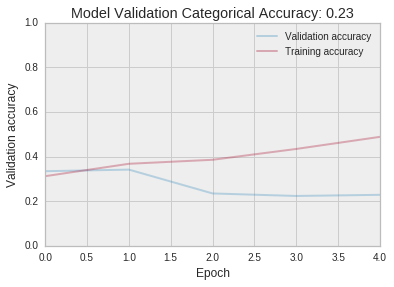

In [18]:
plt.plot(history.history['val_categorical_accuracy'], alpha = 0.3, label = 'Validation accuracy')
plt.plot(history.history['categorical_accuracy'], alpha =  0.3, label = 'Training accuracy')
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.ylim([0,1])
plt.legend(loc = 'best')
plt.title('Model Validation Categorical Accuracy: {0:.2f}'.format(history.history['val_categorical_accuracy'][-1]))
plt.show()

In [19]:
# Predicted lables per movie
preds = pre_model.predict(test_X)
test_Y[0], preds[0]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
 array([  2.94202641e-02,   3.19012880e-01,   8.55141878e-03,
          7.65791675e-03,   3.45789304e-04,   2.59725362e-01,
          4.97983873e-01,   8.33835162e-04,   1.08812451e-02,
          4.35705855e-03,   2.02642828e-02,   1.97756989e-03,
          6.22011430e-04,   1.60465145e-03,   4.34527732e-03,
          1.01963282e-02,   1.23769976e-02,   7.90066645e-03,
          2.71174521e-03,   3.89194232e-04], dtype=float32))

In [20]:
# Precision and Recall
# --Precision: number of true positives over the number of true positives plus the number of false positives
# --Recall: number of true positives over the number of true positives plus the number of false negatives
precision = dict()
average_precision = dict()
recall_score = dict()
recall = dict()
for i in range(20):
    precision[i], recall[i], _ = precision_recall_curve(test_Y[:, i],
                                                        preds[:, i])
    #average_precision[i] = average_precision_score(Y[:, i], preds[:, i])
    recall_score[i] = recall[i].mean()
    average_precision[i] = precision[i].mean()

names = ['id','data']
formats = ['f8','f8']
dtype = dict(names = names, formats=formats)
average_precision_np = pd.DataFrame(np.array(average_precision.items(), dtype=dtype))
average_precision_np['genre'] = list(columns)

recall_score_np = pd.DataFrame(np.array(recall_score.items(), dtype=dtype))
recall_score_np['genre'] = list(columns)

In [21]:
# Sort genres by precision and recall
average_precision_np = average_precision_np.sort_values(by = 'data', ascending=[0])
recall_score_np = recall_score_np.sort_values(by = 'data', ascending=[0])

# Average precision and recall across labels
mean_precision = average_precision_np.data.median()
mean_recall = recall_score_np.data.mean()

# F1 score
F1 = 2*(mean_precision*mean_recall)/(mean_precision+mean_recall)

# Print results
print ("# Overall precision and recall - Pre-trained model #")
print ('Mean Precision:'), round(mean_precision, 4)
print ('Mean Recall:'), round(mean_recall, 4)
print ('F1 Score:'), round(F1, 4)

# Overall precision and recall - Pre-trained model #
Mean Precision: 0.1025
Mean Recall: 0.4942
F1 Score: 0.1698


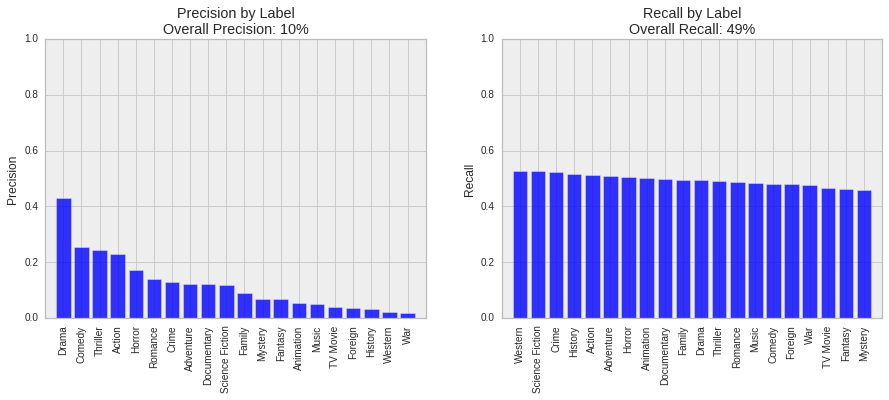

In [22]:
# Precision and recall by label
y_pos = np.arange(len(average_precision_np.genre)) + 1

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 2, 1)

ax1 = plt.bar(y_pos, average_precision_np.data, align='center', alpha=0.8, color='b')
ax1 = plt.xticks(y_pos, average_precision_np.genre, rotation=90)
ax1 = plt.xlim([0,21])
ax1 = plt.ylim([0,1])
ax1 = plt.ylabel('Precision')
ax1 = plt.title('Precision by Label\nOverall Precision: {:.0f}%'.format(mean_precision*100))

ax2 = fig.add_subplot(1, 2, 2)

ax2 = plt.bar(y_pos, recall_score_np.data, align='center', alpha=0.8, color='b')
ax2 = plt.xticks(y_pos, recall_score_np.genre, rotation=90)
ax2 = plt.xlim([0,21])
ax2 = plt.ylim([0,1])
ax2 = plt.ylabel('Recall')
ax2 = plt.title('Recall by Label\nOverall Recall: {:.0f}%'.format(mean_recall*100))

plt.show()